# NeuroCluster:
<font size= 4> Non-parametric cluster-based permutation testing to identify neurophysiological encoding of continuous variables with time-frequency resolution

Authors: Christina Maher & Alexandra Fink-Skular \
Updated: 06/19/2024 by CMM

In [14]:
import numpy as np
import pandas as pd
import mne
from glob import glob
from scipy.stats import zscore, t, linregress, ttest_ind, ttest_rel, ttest_1samp 
import os 
import re
import h5io
import pickle 
import time 
import datetime 
from joblib import Parallel, delayed
import statsmodels.api as sm 
from scipy.ndimage import label 
import statsmodels.formula.api as smf
import tqdm
import operator
import matplotlib.pyplot as plt




import warnings
warnings.filterwarnings('ignore')

# keep this so we can use our respective paths for testing
current_user = 'christina'

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
if current_user == 'christina':
    base_dir = '/Users/christinamaher/Documents/GitHub/NeuroCluster/scripts/'
    data_dir = '/Users/christinamaher/Documents/GitHub/NeuroCluster/'
    tfr_dir  = f'{data_dir}tfr/'
    anat_dir = f'{data_dir}anat/'
elif current_user == 'alie':
    base_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/NeuroCluster/'
    data_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/'
    tfr_dir  = f'{data_dir}ephys_analysis/data/'
    beh_dir  = f'{data_dir}behavior_analysis/behavior_preprocessed/'
    anat_dir = f'{data_dir}anat_recons/'

In [4]:
# load functions 
import sys
sys.path.append(base_dir)
from tfr_cluster_test import *
from helper_utils import *
#from plotting_utils import * 

In [5]:
date = datetime.date.today().strftime('%m%d%Y')
print(date)

06212024


# Step 1: Format Input Data (Currently within-subject)
- neural input: np.array (n_channels x n_epochs x n_freqs x n_times)
- regressor data: np.array (numpy array: n_epochs x n_features)

In [6]:
# load epoched data for single subj
if current_user == 'alie':
    subj_id     = 'MS002'   
    power_epochs = mne.time_frequency.read_tfrs(fname=f'{tfr_dir}{subj_id}/{subj_id}_CpeOnset-tfr.h5')[0]
elif current_user == 'christina':
    subj_id     = 'MS009'   
    power_epochs = mne.time_frequency.read_tfrs(fname=f'{tfr_dir}/{subj_id}_tfr.h5')[0]

Reading /Users/christinamaher/Documents/GitHub/NeuroCluster/tfr//MS009_tfr.h5 ...
Adding metadata with 68 columns


In [7]:
power_epochs.metadata.columns

Index(['lacas1-lacas2', 'lacas2-lacas3', 'lacas3-lacas4', 'lacas4-lacas5',
       'lacas5-lacas6', 'lacas6-lacas7', 'lacas7-lacas8', 'lacas8-lacas9',
       'lacas9-lacas10', 'lagit1-lagit2', 'lagit2-lagit3', 'lagit3-lagit4',
       'lagit4-lagit5', 'lagit8-lagit9', 'lagit9-lagit10', 'laias1-laias2',
       'laias2-laias3', 'laias3-laias4', 'laias4-laias5', 'laias6-laias7',
       'laias7-laias8', 'laias8-laias9', 'laias9-laias10', 'laias10-laias11',
       'lhpit1-lhpit2', 'lhpit2-lhpit3', 'lhpit3-lhpit4', 'lhpit7-lhpit8',
       'lhpit8-lhpit9', 'lhpit9-lhpit10', 'lmcms1-lmcms2', 'lmcms2-lmcms3',
       'lmcms3-lmcms4', 'lmcms4-lmcms5', 'lmcms7-lmcms8', 'lmolf1-lmolf2',
       'lmolf2-lmolf3', 'lmolf3-lmolf4', 'lmolf4-lmolf5', 'lmolf5-lmolf6',
       'lpcpp5-lpcpp6', 'lpcpp6-lpcpp7', 'lpcpp7-lpcpp8', 'lpcpp8-lpcpp9',
       'lpipm1-lpipm2', 'lpipm2-lpipm3', 'lpipm3-lpipm4', 'lpipm4-lpipm5',
       'lpipm5-lpipm6', 'lpipm7-lpipm8', 'lpipm8-lpipm9', 'lpipm9-lpipm10',
       'lpipm10-lp

In [8]:
# set ROI for single ROI anaylsis 
if current_user == 'alie':
    roi = 'ains'
    # set all variables included mutliple regression 
    multi_reg_vars = ['GambleChoice','TotalProfit','RPE','decisionCPE']
    # set main variable of interest for permutations 
    permute_var = 'decisionCPE'
elif current_user == 'christina':
    roi = 'ofc'
    # set all variables included mutliple regression 
    multi_reg_vars = ['rd','ev_zscore','trial_2']
    # set main variable of interest for permutations 
    permute_var = 'ev_zscore'


In [9]:
## new function for getting elecs in ROI
roi = ['lpfc','ofc']
roi_subj_elecs = prepare_anat_dic(roi, f'{anat_dir}master_labels.csv')
roi_subj_elecs

{'MS009': ['laias4-laias5',
  'laias6-laias7',
  'laias7-laias8',
  'laias8-laias9',
  'laias9-laias10',
  'laias10-laias11',
  'lmolf1-lmolf2',
  'lmolf2-lmolf3',
  'lmolf3-lmolf4',
  'lmolf4-lmolf5',
  'lmolf5-lmolf6',
  'lpipm9-lpipm10',
  'lpipm10-lpipm11',
  'lpipm11-lpipm12'],
 'MS011': ['lacas6-lacas7',
  'lacas7-lacas8',
  'lacas8-lacas9',
  'lasenc5-lasenc6',
  'lmolf5-lmolf6',
  'lmolf6-lmolf7',
  'lmolf7-lmolf8',
  'rmolf2-rmolf3',
  'rmolf3-rmolf4',
  'rmolf4-rmolf5',
  'rmolf5-rmolf6',
  'rmolf9-rmolf11'],
 'MS012': ['rmolf1-rmolf2',
  'rmolf2-rmolf4',
  'rmolf4-rmolf5',
  'rmolf5-rmolf6',
  'rmolf9-rmolf10',
  'rmolf10-rmolf11'],
 'MS014': ['raips10-raips11',
  'raips11-raips12',
  'rmcms7-rmcms8',
  'rmcms8-rmcms9',
  'rmolf1-rmolf2',
  'rmolf2-rmolf3',
  'rmolf3-rmolf4',
  'rmolf4-rmolf5',
  'rmolf5-rmolf6',
  'rmolf6-rmolf7',
  'rmolf8-rmolf9'],
 'MS016': ['lacas8-lacas9',
  'lacas9-lacas10',
  'lmolf1-lmolf2',
  'lmolf2-lmolf3',
  'lmolf3-lmolf4',
  'lmolf4-lmolf5',
 

In [10]:
# prepare regressor dataframe: 
# dataframe: shape = n_roi_elecs/subj_id x num covariates
            # all categorical variables should be data type 'pd.category'
            # all continuous variables should be data type 'float64' and zscored *within subject*

if current_user == 'alie':

    roi_subj_beh_df = []

    for subj_id in roi_subj_ids: 
        # load subj behavior data 
        beh_df = pd.read_csv(f'{beh_dir}{subj_id}_task_data')
        # clean subj dataframe from fail trials/nan values in vars of interest 
        # beh_df[~(beh_df.GambleChoice=='gamble')|~(beh_df.GambleChoice=='safe')] = np.nan
        # beh_df = beh_df[~beh_df.Outcome.isnull()]
        beh_df['GambleChoice'][(beh_df.GambleChoice!='gamble')&(beh_df.GambleChoice!='safe')&(~beh_df.GambleChoice.isnull())] = np.nan
        # beh_df = beh_df[(beh_df.GambleChoice=='gamble')|(beh_df.GambleChoice=='safe')]
        # beh_df = beh_df[~beh_df.Outcome.isnull()]
        # set datatypes for categorical vars
        beh_df['GambleChoice'] = beh_df['GambleChoice'].astype('category')
        beh_df['subj_id'] = subj_id
        beh_df[multi_reg_vars[1:]] = pd.DataFrame({f'{var}':zscore(beh_df[var])  for var in multi_reg_vars[1:]})
        # beh_df = beh_df[['subj_id','Round'] + multi_reg_vars]
        beh_df = beh_df[['subj_id','Round'] + multi_reg_vars]    
        roi_subj_beh_df.append(beh_df)

    roi_subj_beh_df = pd.concat(roi_subj_beh_df).reset_index(drop=True)
    roi_subj_beh_df['GambleChoice'] = roi_subj_beh_df['GambleChoice'].astype('category')

elif current_user == 'christina':

    roi_subj_ids = ['MS009'] # for testing, we are just using one subj_id

    roi_subj_beh_df = []

    for subj_id in roi_subj_ids: 
        # load subj behavior data 
        beh_variables = [col for col in power_epochs[0].metadata if col not in power_epochs[0].ch_names]
        beh_df = power_epochs.metadata[beh_variables]
        beh_df['subj_id'] = subj_id
        roi_subj_beh_df.append(beh_df)

    roi_subj_beh_df = pd.concat(roi_subj_beh_df).reset_index(drop=True)

    # assign data types to columns
    roi_subj_beh_df['rd'] = roi_subj_beh_df['rd'].astype('category')
    roi_subj_beh_df['trial_2'] = roi_subj_beh_df['trial_2'].astype('category')
    roi_subj_beh_df['ev_zscore'] = roi_subj_beh_df['ev_zscore'].astype('float64')
    roi_subj_beh_df['subj_id'] = roi_subj_beh_df['subj_id'].astype('category')

# check that the dataframe is correct
roi_subj_beh_df



,trial_2,condition,chosen_shape_current_trial,chosen_color_current_trial,rd,chosen_shape_previous_trial,chosen_color_previous_trial,ev_zscore,ev,subj_id
0,1,no_hint,5,2,shape,NaN,NaN,NaN,NaN,MS009
1,2,no_hint,4,3,shape,5.0,2.0,NaN,NaN,MS009
2,3,no_hint,6,1,shape,4.0,3.0,NaN,NaN,MS009
3,4,no_hint,4,1,shape,6.0,1.0,NaN,NaN,MS009
4,5,no_hint,5,1,shape,4.0,1.0,NaN,NaN,MS009
...,...,...,...,...,...,...,...,...,...,...
211,14,hint,5,2,color,5.0,2.0,1.294003,0.800339,MS009
212,15,hint,6,2,color,5.0,2.0,1.457265,0.835645,MS009
213,16,hint,6,2,color,6.0,2.0,1.593498,0.865105,MS009
214,17,hint,5,2,color,6.0,2.0,0.879600,0.710724,MS009


## Run Univariate Regression 
- Use TFRClusterTest class code to run univariate regression
- Allows for multiple regression implementation and pixel paralellization, so with more speed improvements will ultimately be worth it. (ONGOING DEV)

In [11]:
#### class TFR_Cluster_Test dev + debugging

if current_user == 'alie':

    # subset single electrode tfr data + behav data
    tfr_data = np.squeeze(power_epochs._data[:,16,:,:].copy())
    predictor_data = roi_subj_beh_df[roi_subj_beh_df.subj_id == 'MS002'].drop(columns=['subj_id','Round'])

    test_univar = predictor_data[permute_var].copy()

elif current_user == 'christina':
    
        # subset single electrode tfr data + behav data
        tfr_data = np.squeeze(power_epochs._data[:,0,:,:].copy())
        predictor_data = roi_subj_beh_df[roi_subj_beh_df.subj_id == 'MS009'].drop(columns=['subj_id'])
    
        test_univar = predictor_data[permute_var].copy() # copy of predictor data for univariate testing

In [12]:
uni_test = TFR_Cluster_Test(tfr_data,pd.DataFrame(test_univar),permute_var)
uni_betas, uni_tstats = uni_test.tfr_multireg()
uni_cluster_data = uni_test.max_tfr_cluster(uni_tstats)

uni_cluster_data

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   

pixel regression time:  28.50


[{'clust_stat': 152.5809929119382,
  'freq_idx': (13, 14),
  'time_idx': (734, 766)},
 {'clust_stat': -19143.825877580268,
  'freq_idx': (0, 29),
  'time_idx': (0, 1500)}]

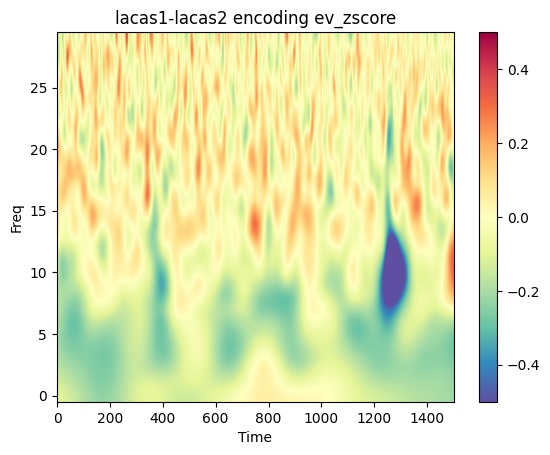

In [15]:
plt.imshow(uni_betas, interpolation = 'Bicubic',cmap='Spectral_r', aspect='auto',origin='lower',vmin=-.5,vmax=.5) 
plt.colorbar()
plt.ylabel('Freq')
plt.xlabel('Time')
plt.title(f'{power_epochs.ch_names[0]} encoding {permute_var}')
plt.show()

## Run Multiple Regression 
- Using TFRClusterTest class
- Need to implement the permutation version of this code (ONGOING DEV)
- Need to add more functionality + plotting utils (ONGOING DEV)

In [16]:
# drop certain columns from predictor data
predictor_data = predictor_data.drop(columns=['condition','chosen_shape_current_trial','chosen_color_current_trial','chosen_shape_previous_trial','chosen_color_previous_trial','ev'])
predictor_data

,trial_2,rd,ev_zscore
0,1,shape,NaN
1,2,shape,NaN
2,3,shape,NaN
3,4,shape,NaN
4,5,shape,NaN
...,...,...,...
211,14,color,1.294003
212,15,color,1.457265
213,16,color,1.593498
214,17,color,0.879600


In [17]:
elec_test = TFR_Cluster_Test(tfr_data,predictor_data,permute_var)
elec_betas, elec_tstats = elec_test.tfr_multireg()
elec_cluster_data = elec_test.max_tfr_cluster(elec_tstats)

elec_cluster_data

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.05411410331726074s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]:

pixel regression time:  44.74


[{'clust_stat': 120.9314269708541, 'freq_idx': (0, 29), 'time_idx': (0, 1500)},
 {'clust_stat': -5872.884195220925,
  'freq_idx': (0, 29),
  'time_idx': (0, 1500)}]

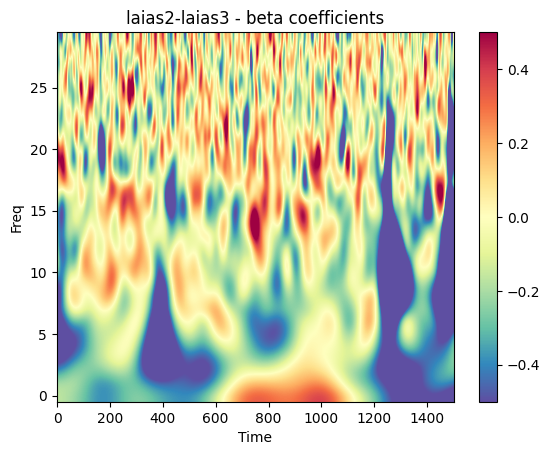

In [18]:
plt.imshow(elec_betas, interpolation = 'Bicubic',cmap='Spectral_r', aspect='auto',origin='lower',vmin=-.5,vmax=.5) 
plt.colorbar()
plt.xlabel('Time')
plt.ylabel('Freq')
plt.title(f'{power_epochs.ch_names[16]} - beta coefficients')
plt.show()

# Step 3: Extract Surrogate Clusters from Pixel-wise Permutation
- For loop for each electrode- 
- Run each permutation (1000x) in parallel within electrode loop
- Calculate max cluster p value for each +/- cluster for each electrode
- Save permuted cluster statistics for each electrode 

DEPENDENCIES: permuted_tfr_cluster_test, tfr_cluster_test

In [19]:
predictor_data

,trial_2,rd,ev_zscore
0,1,shape,NaN
1,2,shape,NaN
2,3,shape,NaN
3,4,shape,NaN
4,5,shape,NaN
...,...,...,...
211,14,color,1.294003
212,15,color,1.457265
213,16,color,1.593498
214,17,color,0.879600


In [21]:
# run univariate regression with permutation testing using run_permutation_test
cluster_test = TFR_Cluster_Test(tfr_data,predictor_data,permute_var)
perm_cluster_results = run_permutation_test(cluster_test, num_permutations=1000)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


In [ ]:
# initialize list to store cluster data
cluster_list = []

for p in range(1000):
    uni_test = TFR_Cluster_Test(tfr_data,pd.DataFrame(test_univar),permute_var,1000)
    _, uni_tstats = uni_test.tfr_multireg()
    cluster_data = uni_test.max_tfr_cluster(uni_tstats,output='cluster_stat') 
    # add permutation number to cluster data
    cluster_data['perm_num'] = p
    del uni_test, uni_tstats # clear memory
    cluster_list.append(cluster_data) 



In [ ]:
### TEST PERMUTATIONS 
num_permutations = 1000
start = time.time() # start timer

all_ch_perm = {}

for c in range(num_channels):
        ch_start = time.time() # start timer

        # Prepare arguments for the permutation function
        permutation_args = [
        (np.squeeze(power_epochs._data[:,c,:,:]), reg_data, tcritical)
        for _ in range(num_permutations)]
    
        # Perform permutations in parallel
        elec_permuted_data = Parallel(n_jobs=-1, verbose=12)(
        delayed(permuted_tfr_cluster_test)(*args)
        for args in permutation_args)
        
        # save in all elec dict 
        all_ch_perm[ch_names[c]] = elec_permuted_data
        pickle.dump(elec_permuted_data, open(f'{results_dir}{subj_id}_{ch_names[c]}_perm_clusters.pkl', "wb")) 

        ch_end = time.time() 
        print(f'{ch_names[c]} permute time: ', '{:.2f}'.format(ch_end-ch_start))
        
        

end = time.time()    
print('{:.2f} s'.format(end-start)) # print time elapsed for computation (approx 4 seconds per permutation)


In [ ]:
num_permutations = 1000
ch_start = time.time() # start timer

# Prepare arguments for the permutation function
permutation_args = [
(np.squeeze(power_epochs._data[:,c,:,:]), reg_data, tcritical)
for _ in range(num_permutations)]

# Perform permutations in parallel
elec_permuted_data_reduc = Parallel(n_jobs=-1, verbose=12)(
delayed(permuted_tfr_cluster_test)(*args)
for args in permutation_args)

# save in all elec dict 
# all_ch_perm[ch_names[c]] = elec_permuted_data
pickle.dump(elec_permuted_data_reduc, open(f'{results_dir}{subj_id}_{ch_names[c]}_reduced_output_perm_clusters.pkl', "wb")) 

ch_end = time.time() 
print(f'{ch_names[c]} permute time: ', '{:.2f}'.format(ch_end-ch_start))

In [ ]:
elec_permuted_data

In [ ]:
elec_permuted_data_reduc